In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.io as spio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy.ndimage import gaussian_filter1d
from scipy import stats

In [3]:
sns.set_style('ticks')
sns.set_context('talk')

In [4]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    
    from: `StackOverflow <http://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries>`_
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return data      

def todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

## Load licking data

In [5]:
df = pd.read_csv("/home/julia/data/reversal_active/hf2.csv", index_col=0)
df = df[df['quality']==1]
df = df[df['licks']==1]

In [6]:
big_dict = {}
for f in df['fnames']:

    mat = loadmat("/home/julia/data/reversal_active/%s.mat"%f)
    trials = [todict(mat["lick_data"][i]) for i in range(len(mat["lick_data"]))]
    big_dict[f] = trials
 

## Organize per trial and performance

In [7]:
df_reduced = pd.DataFrame(columns=['dataset', 'type', 'odor_start', 'iti_start', 'performance', 'licks'])

In [8]:
for f in big_dict.keys():
    for trial in big_dict[f]:
        trial_reduced = {k: trial[k] for k in ('type', 'odor_start', 'iti_start', 'performance')}
        trial_reduced['licks'] = [trial['licks']]
        trial_reduced['dataset'] = f
        df_reduced = df_reduced.append(pd.DataFrame.from_dict(trial_reduced), sort=True)
df_reduced = df_reduced.reset_index()

In [9]:
df_reduced.to_pickle('/home/julia/data/reversal_active/lick_data.pkl')

In [4]:
df_reduced = pd.read_pickle('/home/julia/data/reversal_active/lick_data.pkl')

## Plot licking data aligned to odor start

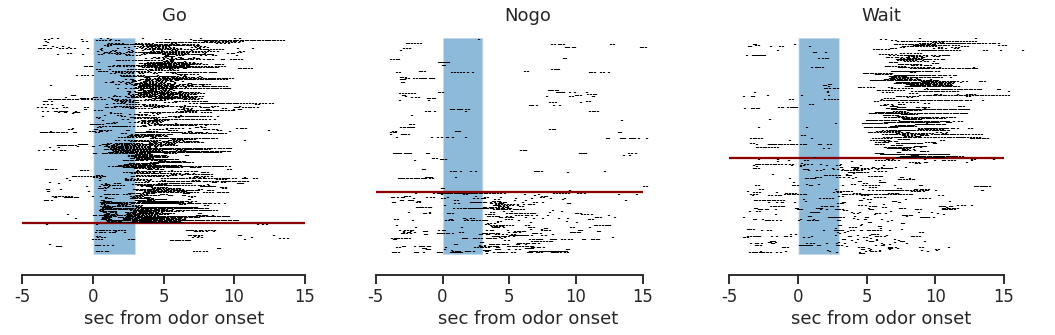

In [11]:
fig=plt.figure(figsize=(15,5))
subplot = 1

for c in ['go', 'nogo', 'wait']:
    df_c = df_reduced[df_reduced['type']==c].reset_index(drop=True)
    df_c0 = df_c[df_c["performance"]==0].reset_index(drop=True)
    df_c1 = df_c[df_c["performance"]==1].reset_index(drop=True)
    
    fig.add_subplot(1,3,subplot)
    subplot += 1
    
    plt.fill_between(np.arange(0,3000,1),3000*[len(df_c)], alpha=0.5)
    
    idx=0
    for row in range(len(df_c0)):
        licks = df_c0.loc[row]['licks']
        plt.vlines(np.where(licks==1)[0]-(df_c0.loc[row]['odor_start']-1), idx+1, idx+2)
        idx+=1
    plt.hlines(idx, -5000, 15000, color="darkred")
    for row in range(len(df_c1)):
        licks = df_c1.loc[row]['licks']
        plt.vlines(np.where(licks==1)[0]-(df_c1.loc[row]['odor_start']-1), idx+1, idx+2)
        idx+=1

    plt.xlabel("sec from odor onset")
    plt.xticks([-5000, 0, 5000, 10000, 15000], [-5, 0, 5, 10, 15])
    plt.yticks([])
    plt.title(c.capitalize())
sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()

## Plot licking data aligned to ITI start

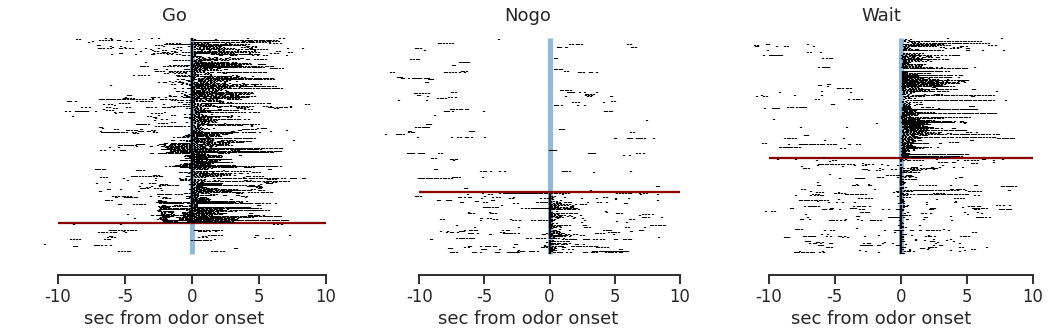

In [12]:
fig=plt.figure(figsize=(15,5))
subplot = 1

for c in ['go', 'nogo', 'wait']:
    df_c = df_reduced[df_reduced['type']==c].reset_index(drop=True)
    df_c0 = df_c[df_c["performance"]==0].reset_index(drop=True)
    df_c1 = df_c[df_c["performance"]==1].reset_index(drop=True)
    
    fig.add_subplot(1,3,subplot)
    subplot += 1
    
    plt.vlines(0, 0, len(df_c), color="C0", linewidth=5, alpha=0.5)
    
    idx=0
    for row in range(len(df_c0)):
        licks = df_c0.loc[row]['licks']
        plt.vlines(np.where(licks==1)[0]-(df_c0.loc[row]['iti_start']-1), idx+1, idx+2)
        idx+=1
    plt.hlines(idx, -10000, 10000, color="darkred")
    for row in range(len(df_c1)):
        licks = df_c1.loc[row]['licks']
        plt.vlines(np.where(licks==1)[0]-(df_c1.loc[row]['iti_start']-1), idx+1, idx+2)
        idx+=1

    plt.xlabel("sec from odor onset")
    plt.xticks([-10000, -5000, 0, 5000, 10000], [-10, -5, 0, 5, 10])
    plt.yticks([])
    plt.title(c.capitalize())

sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()

## Plot only decision period

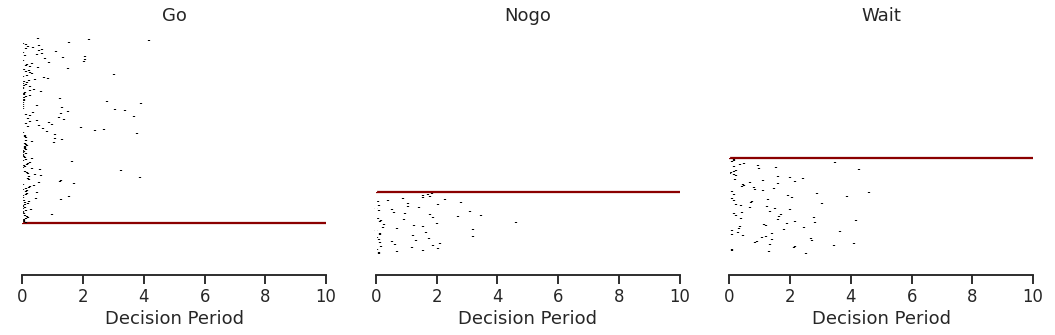

In [13]:
fig=plt.figure(figsize=(15,5))
subplot = 1

for c in ['go', 'nogo', 'wait']:
    df_c = df_reduced[df_reduced['type']==c].reset_index(drop=True)
    df_c0 = df_c[df_c["performance"]==0].reset_index(drop=True)
    df_c1 = df_c[df_c["performance"]==1].reset_index(drop=True)
    
    fig.add_subplot(1,3,subplot)
    subplot += 1
        
    idx=0
    for row in range(len(df_c0)):
        licks = df_c0.loc[row]['licks'][df_c0.loc[row]['odor_start']-1+3000:df_c0.loc[row]['iti_start']+1]
        plt.vlines(np.where(licks==1)[0], idx+1, idx+2)
        plt.vlines(0, idx+1, idx+2, color="white")
        idx+=1
    plt.hlines(idx, 0, 10000, color="darkred")
    for row in range(len(df_c1)):
        licks = df_c1.loc[row]['licks'][df_c1.loc[row]['odor_start']-1+3000:df_c1.loc[row]['iti_start']+1]
        plt.vlines(np.where(licks==1)[0], idx+1, idx+2)
        plt.vlines(0, idx+1, idx+2, color="white")
        idx+=1

    plt.xlabel("Decision Period")
    plt.xticks([0,2000,4000,6000,8000,10000], [0,2,4,6,8,10])
    plt.yticks([])
    plt.title(c.capitalize())

sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()

## Smooth lick rate with Gaussian filter (50ms sdv)

Licks acquired at 1kHz = 1000/sec = 1/ms
Therefore a SDV of 50 is 50 ms (?)

In [5]:
licks_smooth = []
for row in range(len(df_reduced)):
    licks_smooth.append(gaussian_filter1d(df_reduced.loc[row]['licks'], 50, output=np.float64))

In [6]:
df_reduced['licks_smooth'] = licks_smooth

In [7]:
df_reduced.to_pickle('/home/julia/data/reversal_active/lick_data_smooth.pkl')

In [4]:
df_reduced = pd.read_pickle('/home/julia/data/reversal_active/lick_data_smooth.pkl')

### Aligned to odor

In [8]:
licks_odor = []
for row in range(len(df_reduced)):
    licks_odor.append(df_reduced.loc[row]['licks_smooth'][df_reduced.loc[row]['odor_start']-1:])

cut = np.min([len(x) for x in licks_odor])
licks_cut = [x[:cut] for x in licks_odor]

In [9]:
df_licks = df_reduced[['dataset', 'type', 'performance']]
df_licks = df_licks.assign(lick_rate=licks_cut)

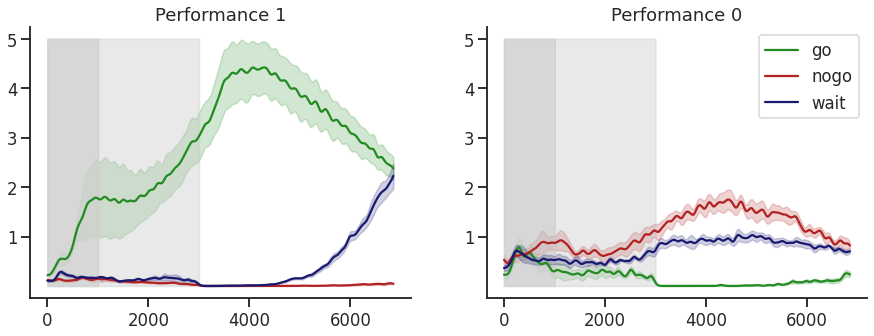

In [10]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

types = ['go', 'nogo', 'wait']
mice = ['SHA', 'TAY', 'UUU', 'VVV', 'WEY', 'XXX', 'YOU']
colors = ['forestgreen', 'firebrick', 'midnightblue']
performances = [1,0]

for c in range(3):
    df_c = df_licks[df_licks['type']==types[c]].reset_index(drop=True)
    
    for p in range(2):
        df_p = df_c[df_c["performance"]==performances[p]].reset_index(drop=True)
    
        L = np.zeros((len(mice), cut))
        for m in range(len(mice)):
            df_m = df_p[df_p['dataset'].str.contains(mice[m])]
            if len(df_m) == 0:
                L[m,:] = np.nan
            else:
                L[m,:] = np.mean(np.stack(df_m['lick_rate']), axis=0)

        x = np.arange(0, L.shape[1])
        y = np.nanmean(L, axis=0)
        sem = stats.sem(L, axis=0, nan_policy='omit')

        ax[p].plot(x, y, color=colors[c], label="{}".format(types[c]))
        ax[p].fill_between(np.arange(0,1000), np.zeros(1000), np.ones(1000)*0.005, color='lightgrey', alpha=0.5)
        ax[p].fill_between(np.arange(1000,3000), np.zeros(2000), np.ones(2000)*0.005, color='lightgrey', alpha=0.2)
        ax[p].fill_between(x, (y-sem), (y+sem), color=colors[c], alpha=.2)
        ax[p].set_yticks([0.001, 0.002, 0.003, 0.004, 0.005])
        ax[p].set_yticklabels([1,2,3,4, 5])
        ax[p].set_title('Performance {}'.format(performances[p]))
        sns.despine()
        
    ax[p].legend()

### Aligned to ITI

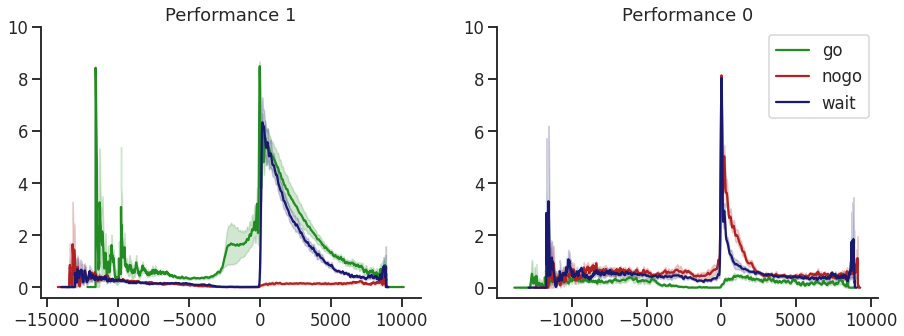

In [71]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

types = ['go', 'nogo', 'wait']
colors = ['forestgreen', 'firebrick', 'midnightblue']
mice = ['SHA', 'TAY', 'UUU', 'VVV', 'WEY', 'YOU']
performances = [1,0]

for c in range(len(types)):
    
    for p in range(len(performances)):
    
        means = []
        for m in range(len(mice)):
            df_single = df_reduced[(df_reduced['type']==types[c]) & 
                                   (df_reduced["performance"]==performances[p]) &
                                   (df_reduced['dataset'].str.contains(mice[m]))].reset_index(drop=True)
             
            df_iti = pd.DataFrame()
            series = []
            for row in range(len(df_single)):
                licks = df_single.loc[row, 'licks_smooth']
                zero_idx = df_single.loc[row, 'iti_start']-1
                series.append(pd.Series(name=row, data=licks, 
                                   index=np.arange(-zero_idx, -zero_idx+licks.shape[0])))
            df_iti = pd.DataFrame(series[0])
            df_iti = df_iti.join(series[1:], how='outer')
            means.append(pd.Series(data=np.nanmean(df_iti, axis=1), index=df_iti.index, name=mice[m]))
        
        df_means = pd.DataFrame(means[0])
        df_means = df_means.join(means[1:], how='outer')

        x = df_means.index
        y = np.nanmean(df_means, axis=1)
        sem = stats.sem(df_means, axis=1, nan_policy='omit')
        
        ax[p].plot(x, y, color=colors[c], label="{}".format(types[c]))
        #ax[p].fill_between(np.arange(0,1000), np.zeros(1000), np.ones(1000)*0.005, color='lightgrey', alpha=0.5)
        #ax[p].fill_between(np.arange(1000,3000), np.zeros(2000), np.ones(2000)*0.005, color='lightgrey', alpha=0.2)
        ax[p].fill_between(x, (y-sem), (y+sem), color=colors[c], alpha=.2)
        ax[p].set_yticks([0, 0.002, 0.004, 0.006, 0.008, 0.010])
        ax[p].set_yticklabels([0,2,4,6,8,10])
        ax[p].set_title('Performance {}'.format(performances[p]))
        sns.despine()
    ax[p].legend()

## Separate pre- and post reversal

In [80]:
df = pd.read_csv("/home/julia/data/reversal_active/hf2.csv", index_col=0)
df = df[df['quality']==1]
df = df[df['licks']==1]

In [90]:
days_rev = []
for row in range(len(df_reduced)):
    day = df[df['fnames']==df_reduced.loc[row, 'dataset']]['DfromRev'].values[0]
    days_rev.append(day)

In [93]:
df_reduced['day_rev'] = days_rev

In [95]:
df_pre = df_reduced[df_reduced['day_rev']<0]